In [1]:
import pandas as pd
import numpy as np
import dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Load Dataset

In [2]:
df = pd.read_parquet('dataset.parquet')

In [3]:
df

time  sample  anomaly  category  setting  action  active  \
0         0.000000       0     True         0        0       0       0   
1         0.010047       0     True         0        0       0       0   
2         0.020135       0     True         0        0       0       0   
3         0.030203       0     True         0        0       0       0   
4         0.040257       0     True         0        0       0       0   
...            ...     ...      ...       ...      ...     ...     ...   
2321685  10.716863    2121    False        12       76      13       1   
2321686  10.726921    2121    False        12       76      13       1   
2321687  10.737022    2121    False        12       76      13       1   
2321688  10.747115    2121    False        12       76      13       1   
2321689  10.757177    2121    False        12       76      13       1   

         robot_voltage  robot_current  io_current  ...  torque_sensor_a_6  \
0            48.582687       0.322263    0.087890  ...           0.069086   
1            48.582687       0.527340    0.087890  ...           0.055269   
2            48.561890       0.380857    0.087890  ...           0.060796   
3            48.582687       0.483395    0.087890  ...           0.046979   
4            48.582687       0.307615    0.087890  ...           0.046979   
...                ...            ...         ...  ...                ...   
2321685      48.561890       0.688472    0.087890  ...           0.055269   
2321686      48.561890       0.644527    0.073242  ...           0.041452   
2321687      48.541092       0.908197    0.087890  ...           0.066323   
2321688      48.582687       0.688472    0.117187  ...           0.069086   
2321689      48.582687       0.703120    0.087890  ...           0.066323   

         torque_sensor_b_6  motor_iq_6  motor_id_6  power_motor_el_6  \
0                -0.066240    0.161936   -0.019600          0.115915   
1                -0.063480    0.142992    0.020944          0.134123   
2                -0.080041    0.145380    0.011475          0.115405   
3                -0.066240    0.147767    0.002005          0.097916   
4                -0.074521    0.147767    0.002005          0.104346   
...                    ...         ...         ...               ...   
2321685          -0.063480    0.133460    0.024379          0.103935   
2321686          -0.044160    0.142870    0.021766          0.078053   
2321687          -0.049680    0.124408   -0.008216          0.080420   
2321688          -0.044160    0.124408   -0.008216          0.092157   
2321689          -0.052440    0.131376   -0.001374          0.073302   

         power_motor_mech_6  power_load_mech_6  motor_voltage_6  \
0                       0.0       1.157006e-05         0.729223   
1                       0.0      -7.832955e-07         0.630203   
2                       0.0       4.344085e-07         0.620702   
3                       0.0       2.882664e-06         0.623614   
4                       0.0       6.304338e-07         0.499930   
...                     ...                ...              ...   
2321685                 0.0      -1.502957e-05         0.595642   
2321686                 0.0       7.213437e-07         0.517480   
2321687                 0.0       9.829410e-06         0.496470   
2321688                 0.0       7.721170e-06         0.817346   
2321689                 0.0       8.201027e-06         0.466415   

         supply_voltage_6  brake_voltage_6  
0               47.783798        11.177029  
1               47.783798        10.976003  
2               47.803898        11.217231  
3               47.783798        11.177029  
4               47.803898        11.156923  
...                   ...              ...  
2321685         47.803898        11.217231  
2321686         47.803898        10.976000  
2321687         47.783798        11.197131  
2321688         47.783798        11.116721  
2321689         47.783798        11

In [4]:
# Excluding ['time','sample','category','setting','action','active']
df = df.drop(['time','sample','category','setting','action','active'], axis=1)

# Converting the column 'anomaly' from boolean to int
df['anomaly'] = df['anomaly'].astype(int)

In [5]:
df

anomaly  robot_voltage  robot_current  io_current  system_current  \
0              1      48.582687       0.322263    0.087890        0.278318   
1              1      48.582687       0.527340    0.087890        0.410153   
2              1      48.561890       0.380857    0.087890        0.292967   
3              1      48.582687       0.483395    0.087890        0.263670   
4              1      48.582687       0.307615    0.087890        0.263670   
...          ...            ...            ...         ...             ...   
2321685        0      48.561890       0.688472    0.087890        0.263670   
2321686        0      48.561890       0.644527    0.073242        0.219725   
2321687        0      48.541092       0.908197    0.087890        0.263670   
2321688        0      48.582687       0.688472    0.117187        0.278318   
2321689        0      48.582687       0.703120    0.087890        0.278318   

         target_position_1  target_velocity_1  target_acceleration_1  \
0                -0.341433               -0.0                   -0.0   
1                -0.341433               -0.0                   -0.0   
2                -0.341433               -0.0                   -0.0   
3                -0.341433               -0.0                   -0.0   
4                -0.341433               -0.0                   -0.0   
...                    ...                ...                    ...   
2321685          -0.341433               -0.0                   -0.0   
2321686          -0.341433               -0.0                   -0.0   
2321687          -0.341433               -0.0                   -0.0   
2321688          -0.341433               -0.0                   -0.0   
2321689          -0.341433               -0.0                   -0.0   

         target_torque_1  computed_inertia_1  ...  torque_sensor_a_6  \
0               0.127406            2.251855  ...           0.069086   
1               0.314227            2.251855  ...           0.055269   
2               0.002657            2.251855  ...           0.060796   
3              -0.128248            2.251855  ...           0.046979   
4               0.097738            2.251855  ...           0.046979   
...                  ...                 ...  ...                ...   
2321685        -1.652499            2.251218  ...           0.055269   
2321686        -1.703043            2.251505  ...           0.041452   
2321687        -1.405120            2.251686  ...           0.066323   
2321688        -1.668486            2.251787  ...           0.069086   
2321689        -1.634014            2.251834  ...           0.066323   

         torque_sensor_b_6  motor_iq_6  motor_id_6  power_motor_el_6  \
0                -0.066240    0.161936   -0.019600          0.115915   
1                -0.063480    0.142992    0.020944          0.134123   
2                -0.080041    0.145380    0.011475          0.115405   
3                -0.066240    0.147767    0.002005          0.097916   
4                -0.074521    0.147767    0.002005          0.104346   
...                    ...         ...         ...               ...   
2321685          -0.063480    0.133460    0.024379          0.103935   
2321686          -0.044160    0.142870    0.021766          0.078053   
2321687          -0.049680    0.124408   -0.008216          0.080420   
2321688          -0.044160    0.124408   -0.008216          0.092157   
2321689          -0.052440    0.131376   -0.001374          0.073302   

         power_motor_mech_6  power_load_mech_6  motor_voltage_6  \
0                       0.0       1.157006e-05         0.729223   
1                       0.0      -7.832955e-07         0.630203   
2                       0.0       4.344085e-07         0.620702   
3                       0.0       2.882664e-06         0.623614   
4                       0.0       6.304338e-07         0.499930   
...                     ...                ...              ...   
2321685 

In [6]:
X = df.drop('anomaly', axis=1)
y = df['anomaly']

# PCA dimensionality selection

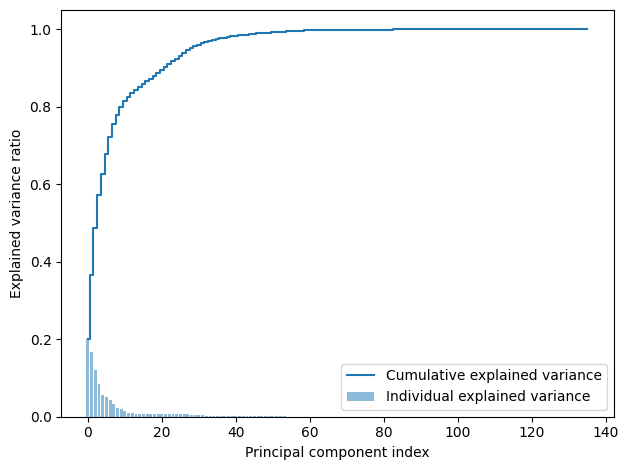

In [18]:
inertias = []

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# PCA Reduction

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_scaled)

In [8]:
X_pca_clustered = pd.DataFrame(X_pca, columns=['Principle_Component_' + str(i) for i in range(1,21)])
X_pca_clustered['anomaly'] = y

In [9]:
X_pca_clustered

Principle_Component_1  Principle_Component_2  Principle_Component_3  \
0                     5.102030              -3.064805              -1.140226   
1                     5.123957              -3.083819              -0.996841   
2                     5.118617              -3.097454              -0.984397   
3                     5.073363              -3.179608              -1.104459   
4                     4.889748              -3.266315              -1.413869   
...                        ...                    ...                    ...   
2321685               6.976449              -4.567215               0.975802   
2321686               6.920235              -4.460806               0.538005   
2321687               6.877172              -4.284648               0.436768   
2321688               6.282209              -4.056817              -0.326403   
2321689               5.888068              -3.627755              -0.487884   

         Principle_Component_4  Principle_Component_5  Principle_Component_6  \
0                    -1.180850               1.589555              -0.387200   
1                    -1.054302               1.492265              -0.311538   
2                    -1.049419               1.480586              -0.341601   
3                    -1.159724               1.531929              -0.405902   
4                    -1.443021               1.756588              -0.631291   
...                        ...                    ...                    ...   
2321685              -2.225261               5.319517               2.016111   
2321686              -2.089330               4.631029               1.440377   
2321687              -1.758756               4.110125               1.516273   
2321688              -1.856184               3.511985               0.512620   
2321689              -1.413987               2.877092              -0.093755   

         Principle_Component_7  Principle_Component_8  Principle_Component_9  \
0                    -1.170797              -3.111132              -0.308769   
1                    -1.203242              -3.048781              -0.293039   
2                    -1.177775              -3.053212              -0.323517   
3                    -1.130791              -3.085628              -0.325759   
4                    -1.096757              -3.203219              -0.244664   
...                        ...                    ...                    ...   
2321685               3.484075              -1.700846               0.163710   
2321686               2.984600              -1.755022               0.222164   
2321687               2.437928              -1.472199              -0.042918   
2321688               1.400080              -1.948241               0.064094   
2321689               0.540184              -2.278030               0.010652   

         Principle_Component_10  ...  Principle_Component_12  \
0                      0.121423  ...               -0.645313   
1                      0.206475  ...               -0.167063   
2                      0.227097  ...               -0.599419   
3                      0.061461  ...                0.336494   
4                     -0.009239  ...               -0.980329   
...                         ...  ...                     ...   
2321685                1.458142  ...               -0.403609   
2321686                1.207157  ...                0.028949   
2321687                1.186889  ...                0.466024   
2321688                0.684349  ...               -3.168668   
2321689                0.580635  ...               -0.317055   

         Principle_Component_13  Principle_Component_14  \
0                     -0.074099               -0.114195   
1                      0.144681               -1.529228   
2                     -0.169227               -0.318854   
3                     -0.796404               -0.369257   
4                     -0.799861               -0.376726   
...

In [10]:
X_pca_clustered.to_parquet('dataset_pca.parquet')

In [21]:
X_pca_clustered.to_csv('dataset_pca.csv', index=False)

# PCA Viz

In [27]:
data = X_pca_clustered.copy()
data['anomaly'] = data['anomaly'].apply(lambda x: 'Anomalous' if x == 1 else 'Normal')

def plot_PCA(data, pc_ith, pc_jth):

    colors = sns.color_palette("hls", 8)
    red = colors[0]
    green = colors[3]
    
    colors_list = [red, green]
    category_order = ["Anomalous", "Normal"]

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=data,
                    x=pc_ith,
                    y=pc_jth,
                    hue='anomaly',
                    palette=colors_list, 
                    hue_order=category_order)
    plt.title(pc_ith + ' vs ' + pc_jth)
    plt.legend(title='Label', loc='upper right')
    plt.show()

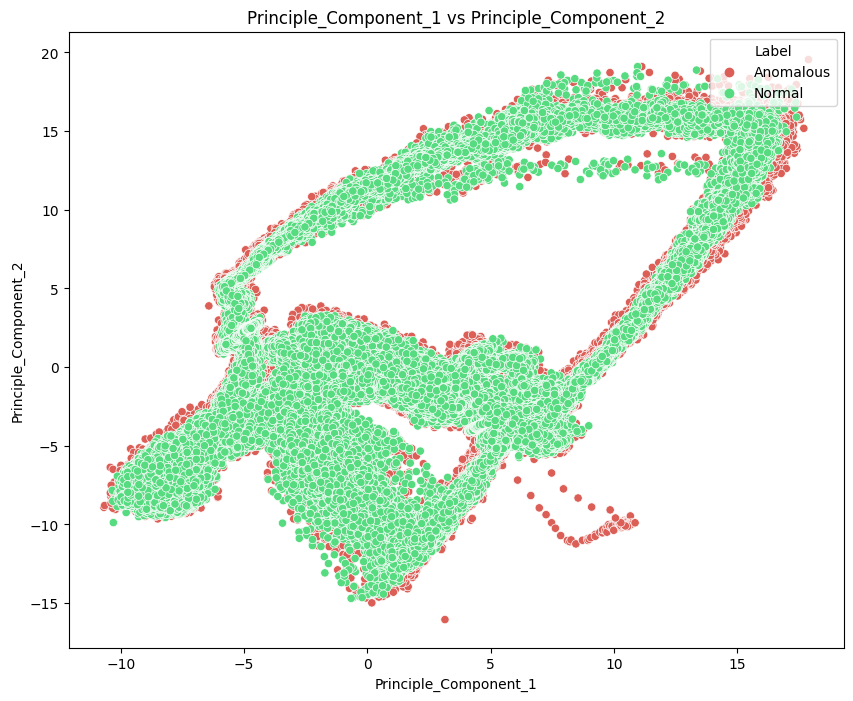

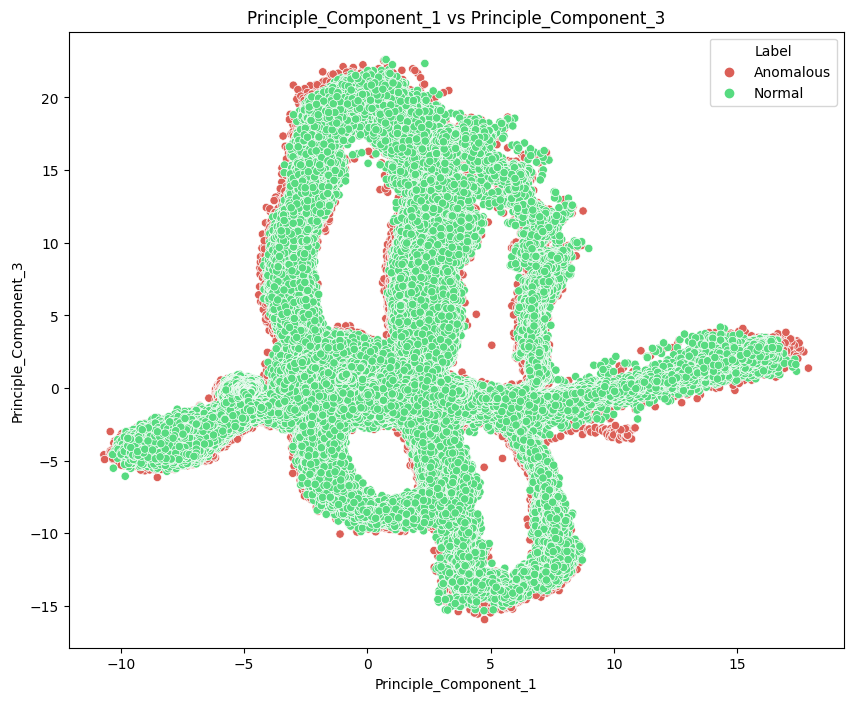

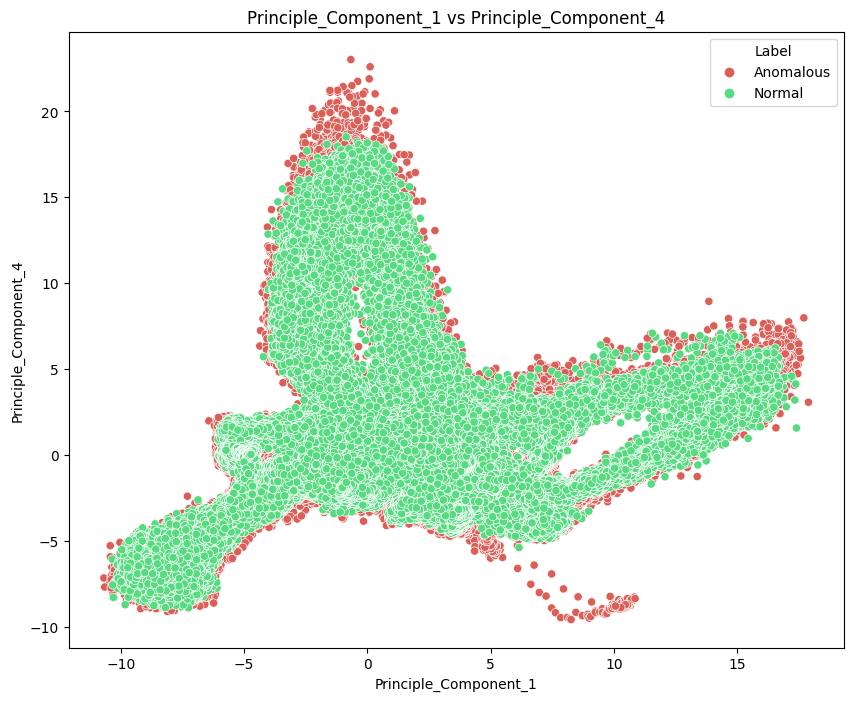

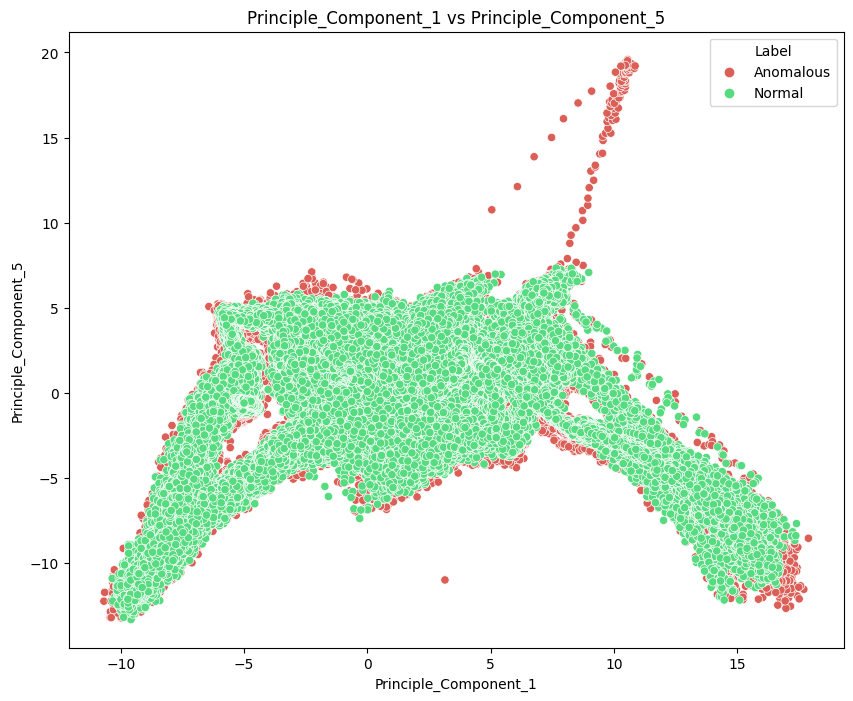

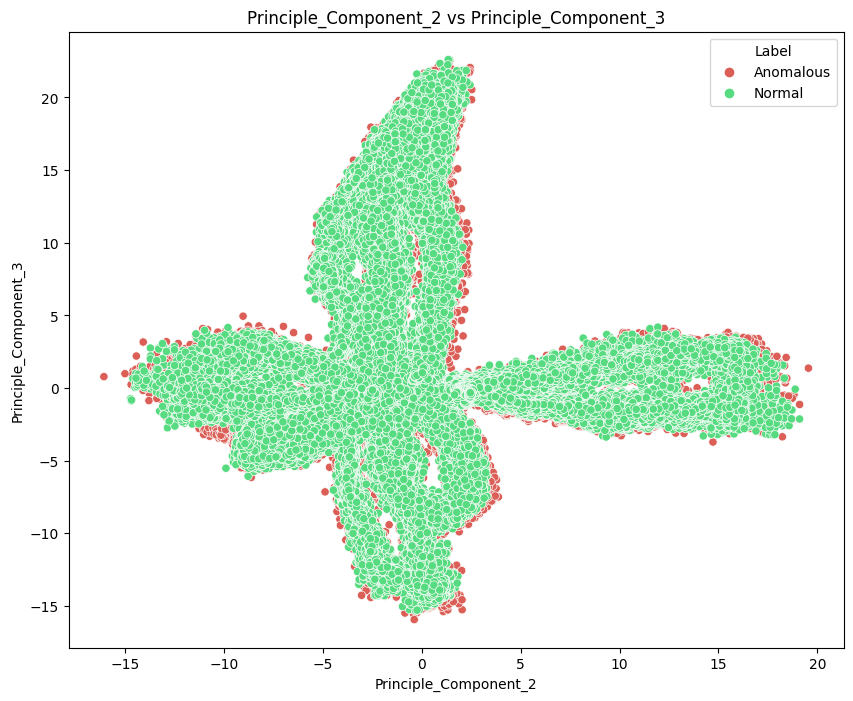

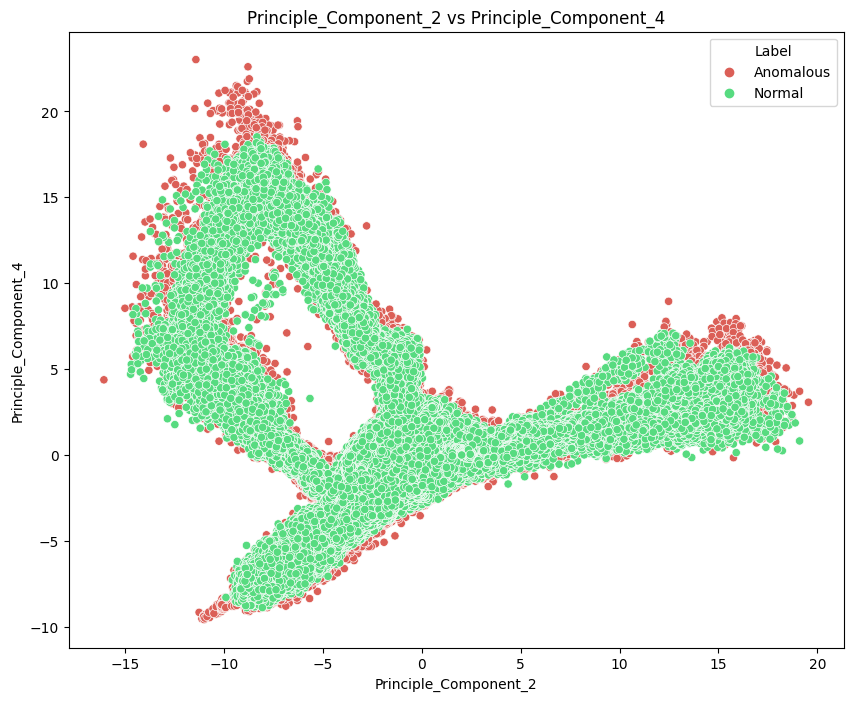

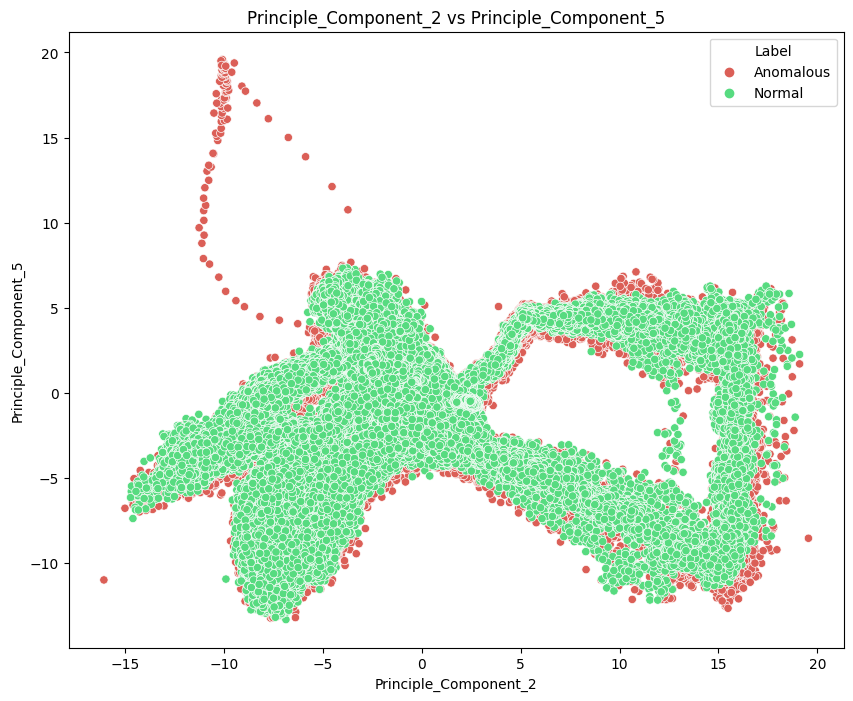

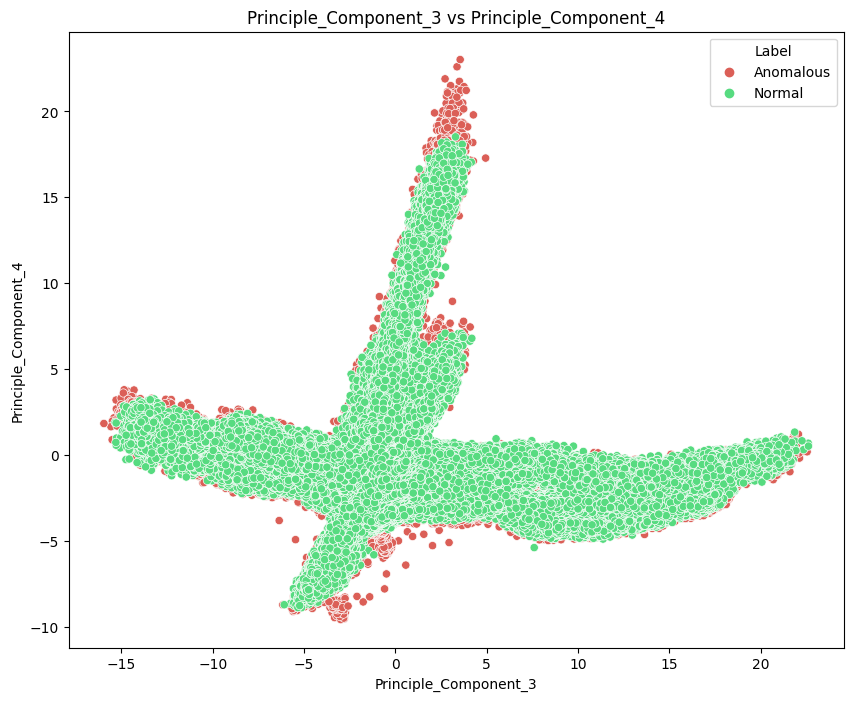

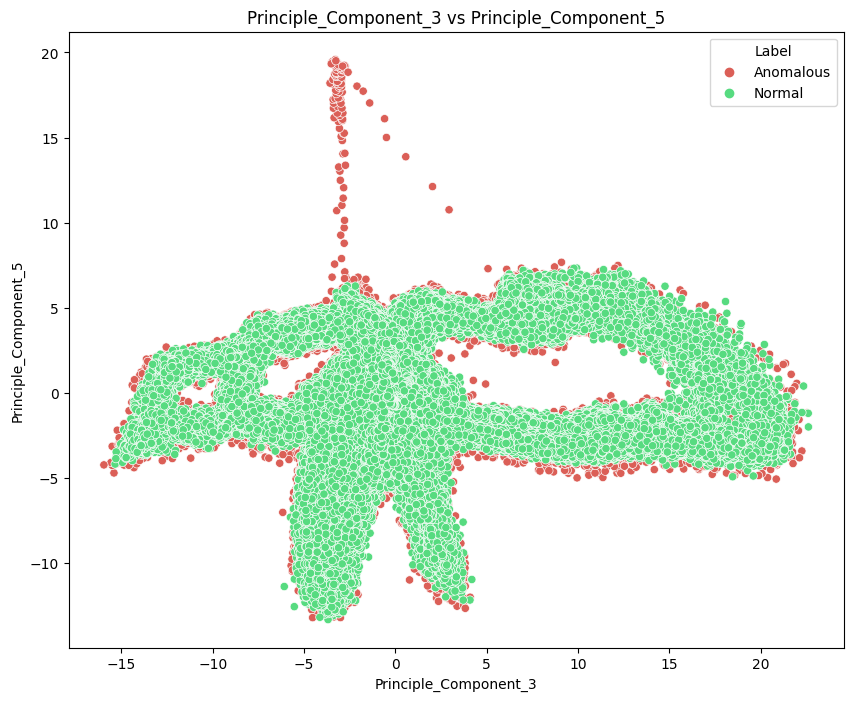

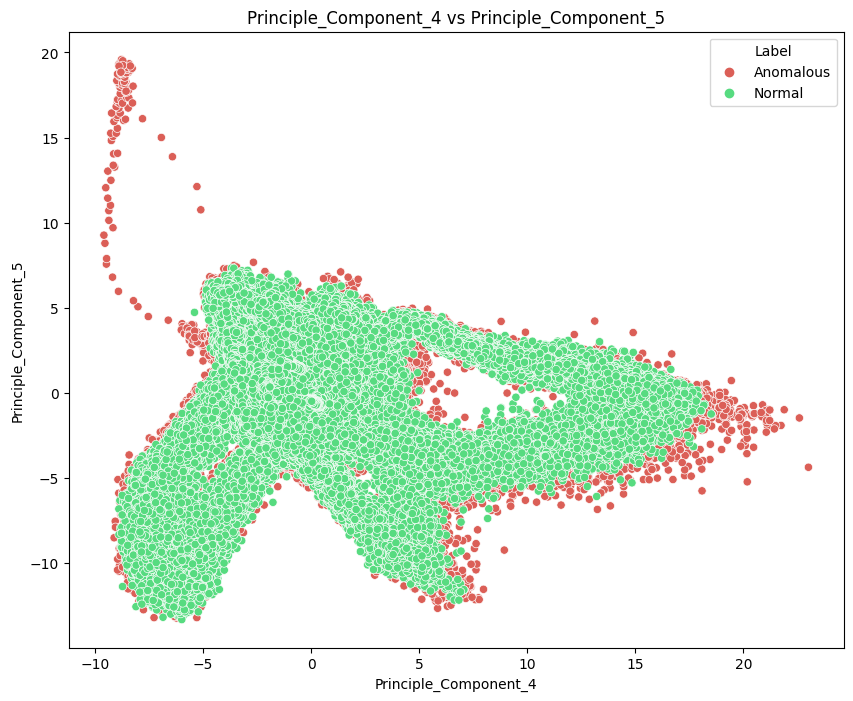

In [29]:
for i in range(1, 5):
    for j in range(i+1, 6):
        if i != j:
            plot_PCA(data, 'Principle_Component_' + str(i), 'Principle_Component_' + str(j))